In [461]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sympy as sp

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [8,6]

# E1)
### a) Constants

In [462]:
#Constants for qubit A
E_JA = 4
E_CA = 1
E_LA = 0.9
w_A = 0.499

#Constants for qubit B
E_JB = 4
E_CB = 1
E_LB = 1
w_B = 0.581

J_L = 0.002
# J_C is the free parameter

In [463]:
def n2Matrix(cutoff, dimension):
    delta = 2*cutoff/dimension
    diagArr = np.ones(dimension)
    offDiagArr = np.ones(dimension-1)
    n2Matrix = 1/delta**2 * (2*np.diag(diagArr) - np.diag(offDiagArr, k = 1) - np.diag(offDiagArr, k = -1))
    return n2Matrix

def nMatrix(cutoff, dimension):
    delta = 2*cutoff/dimension
    offDiagArr = np.ones(dimension-1)
    nMatrix = 1j/(2*delta) * (np.diag(offDiagArr, k = -1) - np.diag(offDiagArr, k = 1))
    return nMatrix

def potMatrix(cutoff, dimension, E_J, E_L):
    phi = np.linspace(-cutoff, cutoff, dimension)
    cosMatrix = -E_J * np.diag(np.cos(phi - np.pi))
    phi2Matrix = E_L * np.diag(phi**2)

    pot_arr = E_L * phi**2-E_J * np.cos(phi - np.pi)
    return cosMatrix + phi2Matrix , pot_arr, phi


### b) Hamiltonians

In [464]:
dim = 30
cutoff = 2*np.pi

def qubit_H(E_C, E_J, E_L, dimension = dim, cut = cutoff):
    E_kin = 4*E_C*n2Matrix(cut, dimension)
    E_pot, potential, phi = potMatrix(cut, dimension, E_J, E_L)
    return E_kin + E_pot, potential, phi


## Convergence test

I'm checking how small I can make the single qubit hamiltonians so that when couple them I can work with the smallest possible matrix

In [465]:
dim_range = np.arange(6, 50, 1)
cut_range = np.arange(0.4, 5, 0.2) * np.pi

energy0, energy1, energy2 = np.zeros((len(dim_range), len(cut_range))), np.zeros((len(dim_range), len(cut_range))), np.zeros((len(dim_range), len(cut_range)))


for i, dim_val in enumerate(dim_range):
    for j, cut_val in enumerate(cut_range):
        Hamilton, potential, phi = qubit_H(E_CA, E_JA, E_LA, dimension=dim_val, cut=cut_val)
        energy, state = sc.sparse.linalg.eigsh(Hamilton, k = 4, which = "SA")

        energy0[i][j], energy1[i][j], energy2[i][j] = energy[0], energy[1], energy[2]


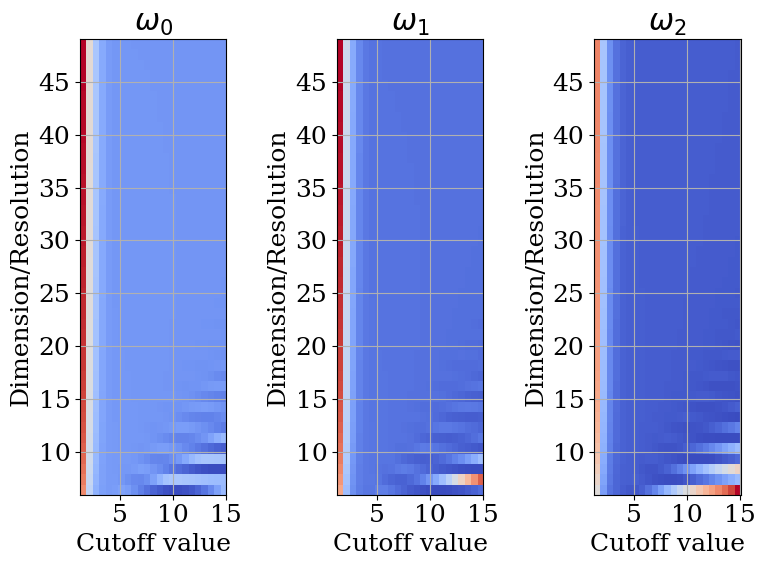

In [466]:
X, Y = np.meshgrid(cut_range, dim_range)

fig, ax = plt.subplots(1, 3)

im0 = ax[0].imshow(energy0, cmap="coolwarm", extent=[min(cut_range), max(cut_range), min(dim_range), max(dim_range)], origin = "lower")
im1 = ax[1].imshow(energy1, cmap="coolwarm", extent=[min(cut_range), max(cut_range), min(dim_range), max(dim_range)], origin = "lower")
im2 = ax[2].imshow(energy2, cmap="coolwarm", extent=[min(cut_range), max(cut_range), min(dim_range), max(dim_range)], origin = "lower")

ax[0].set(xlabel="Cutoff value", ylabel = "Dimension/Resolution", title = "$\omega_0$")
ax[1].set(xlabel="Cutoff value", ylabel = "Dimension/Resolution", title = "$\omega_1$")
ax[2].set(xlabel="Cutoff value", ylabel = "Dimension/Resolution", title = "$\omega_2$")

fig.tight_layout()

So appropriate value would be dim=20 and cutoff=3 $\pi$

In [467]:
minimal_dim = 30
minimal_cut = 3.5*np.pi

#The coupling hamiltonian
def coupling_H(J_c, dim = minimal_dim, cutoff = minimal_cut, J_Lc = J_L):
    n = nMatrix(cutoff, dim)
    phiMatrix = np.diag(np.linspace(-cutoff, cutoff, dim))
    coupled_matrix = J_c * np.kron(n, n) - J_Lc * np.kron(phiMatrix, phiMatrix)

    return coupled_matrix

In [468]:
def total_H(J_c): #Combining everything into the total hamiltonian
    H_A, pot, phi = qubit_H(E_CA, E_JA, E_LA, dimension = minimal_dim, cut = minimal_cut)
    H_B, pot, phi = qubit_H(E_CB, E_JB, E_LB, dimension = minimal_dim, cut = minimal_cut)
    H = np.kron(H_A, np.identity(minimal_dim)) + np.kron(np.identity(minimal_dim), H_B) + coupling_H(J_c)
    return H


In [469]:
#Identifying states
H_A, pot, phi = qubit_H(E_CA, E_JA, E_LA, dimension = minimal_dim, cut = minimal_cut)
H_B, pot, phi = qubit_H(E_CB, E_JB, E_LB, dimension = minimal_dim, cut = minimal_cut)
H_no_coupling = np.kron(H_A, np.identity(minimal_dim)) + np.kron(np.identity(minimal_dim), H_B)
 
print(H_no_coupling.shape)

energies, states = sc.sparse.linalg.eigsh(H_no_coupling, k = 8, which="SA")

state00 = states[:,0]
state10 = states[:,1]
state01 = states[:,2]
state11 = states[:,3]

#Checking equation (10)
phi_mat = np.diag(np.linspace(-minimal_cut, minimal_cut, minimal_dim))
mu_mat = np.kron(phi_mat, np.identity(minimal_dim))


print(abs(state00@mu_mat@state01)) #This is the nominator in equation (10). This is essentially zero as expected

(900, 900)
1.4016565685892601e-14


In [470]:
J_C_arr = np.linspace(0, 0.08, 110) #J_c runs from 0 to 80 MHz which is 0.08 GHz

ZZ_coupling_rate = np.zeros_like(J_C_arr)
mu_phi = np.zeros_like(J_C_arr)

for i, val in enumerate(J_C_arr):
    Hamil = total_H(val)

    energies_JC, states_JC = sc.sparse.linalg.eigsh(Hamil, k = 8, which="SA")

    mu_phi[i] = abs(states_JC[:,0]@mu_mat@states_JC[:,2])/abs(states_JC[:,0]@mu_mat@states_JC[:,1])

    ZZ_coupling_rate[i] = abs(energies_JC[0] + energies_JC[3] - energies_JC[1] - energies_JC[2])


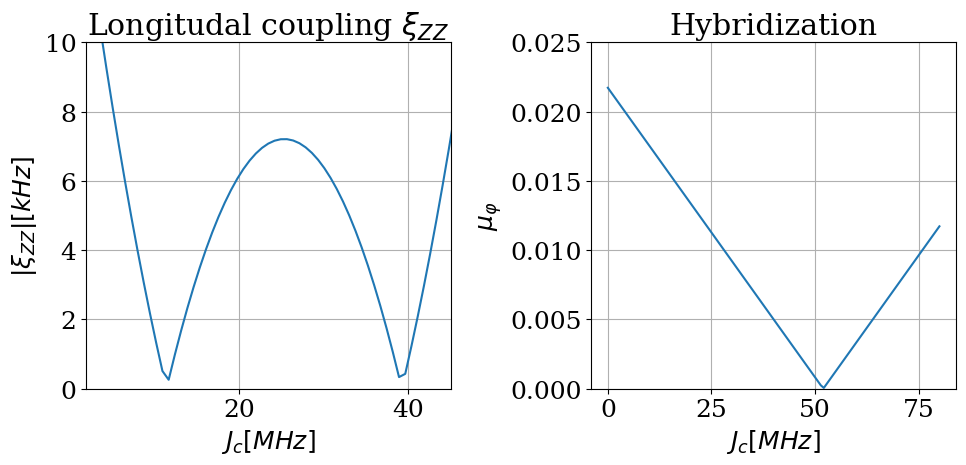

In [490]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(J_C_arr*1e3, ZZ_coupling_rate*1e6)
ax[0].set(ylim=(0, 10), xlim=(2,45))
ax[0].set(xlabel=r"$J_c [MHz]$", ylabel=r"$|\xi_{ZZ}| [kHz]$", title = r"Longitudinal coupling $\xi_{ZZ}$")


ax[1].plot(J_C_arr[mu_phi<1]*1e3, mu_phi[mu_phi<1])
ax[1].set(ylim=(0, 0.025)) #xlim=(2,45)
ax[1].set(xlabel=r"$J_c[MHz]$", ylabel=r"$\mu_{\varphi}$", title = "Hybridization")

fig.tight_layout()

# E2)

In [472]:
subspace_dimension = 20

#The envolope function 
def envolope(t, t_ramp, e_d, t_g): #t_g is simply the gate time
    t_up = np.array(e_d/2 * (1 - np.cos(np.pi * t[t<t_ramp] / t_ramp)))
    t_flat = np.array(e_d * np.ones(len(t[(t > t_ramp) & (t < t_g-t_ramp)])))
    t_down = np.array(e_d/2 * (1 - np.cos(np.pi *(t_g - t[t >t_g - t_ramp]) / t_ramp)))
    t_first = np.concatenate((t_up, t_flat))
    pulse = np.concatenate((t_first, t_down))
    return pulse

def envolope_cond(t, t_ramp, e_d, t_g):
    val = 0
    if(t<t_ramp):
        val = np.array(e_d/2 * (1 - np.cos(np.pi * t / t_ramp)))
    elif((t > t_ramp) & (t < t_g-t_ramp)):
        val = np.array(e_d * np.ones(len(t[(t > t_ramp) & (t < t_g-t_ramp)])))
    elif((t >t_g - t_ramp) & (t<t_g)):
        val = np.array(e_d/2 * (1 - np.cos(np.pi *(t_g - t) / t_ramp)))    
    else:
        val = 0 
    return val   


def drive_hamiltonian(omega_d, t, t_r, t_gate, e_A, e_B):
    A_part = envolope_cond(t, t_r, e_A, t_gate) * np.cos(omega_d * t) * np.kron(phi_mat, np.identity(minimal_dim))
    B_part = envolope_cond(t, t_r, e_B, t_gate) * np.cos(omega_d * t) * np.kron(np.identity(minimal_dim), phi_mat)
    H = A_part + B_part
    return H



In [473]:
def convert_to_subspace(operator, dimension):
    eigenval, eigenvect = sc.sparse.linalg.eigsh(operator, k = dimension, which = "SA")

    new_operator = np.ones((dimension, dimension), dtype=complex)

    for i in range(dimension):
        for j in range(dimension):
            new_operator[i][j] = eigenvect[:,i]@operator@eigenvect[:,j]

    return new_operator


With all these functions we can now express the total Hamiltonian in the 20x20 subspace

In [474]:
J_C = 0.0115

gate_time, ramp_time = 50, 200

def H_combined(time):
    H_coup = total_H(J_C)
    H_d = drive_hamiltonian(omega_d = w_B, t = time, t_r = ramp_time, t_gate = gate_time, e_A = 0.01, e_B = 0.01)
    return H_coup + H_d

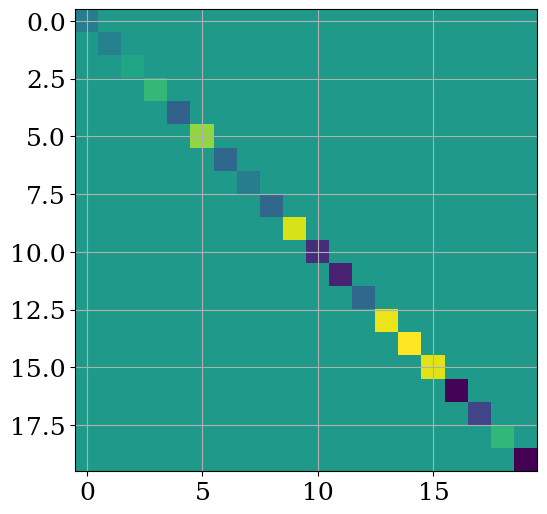

In [475]:
Hamiltonian = H_combined(30)

hamiltonian_20 = convert_to_subspace(Hamiltonian, 20)

plt.imshow(hamiltonian_20.real)